In [4]:
# a small tutorial on how to use the main class of the repo `PathShadowing`
import os 
from pathlib import Path
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt

from scatspectra import (
    windows, analyze, generate, plot_dashboard, compute_smile,
    PriceData, MRWGenerator, SPDaily
)
from shadowing import (
    Softmax, PathShadowing, Foveal, RelativeMSE, PredictionContext, 
    ArrayType, realized_variance, plot_volatility
)
    
CACHE_PATH = Path(os.getcwd()) / '_cache'  # replace with your own cache path

def _torch(x: ArrayType) -> torch.Tensor:
    """ Convert x to a torch float tensor. """
    if isinstance(x, torch.Tensor):
        return x
    return torch.tensor(x, dtype=torch.float32)

# Conventions

The time-series data in the code and in this notebook is stored as arrays of shape B, N, T with:
- B the batch size: the number of (possibly independent) realizations in x
- N the number of channels, N=1 for a univariate time-series, N>1 or a multi-variate time-series
- T the number of time samples

Financial time-series requires to deal with prices, log-prices, returns, log-returns. \
Instead of having to manually go from prices to log-returns or from returns to log-prices, \
the class PriceData handles it for you. See quick example below.

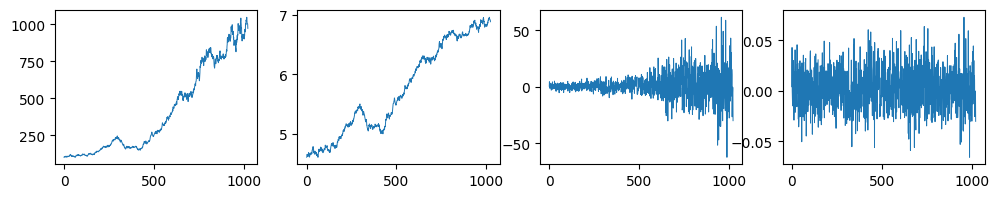

In [17]:
# initialize log-returns 
dlnx = np.random.randn(1024) * 0.02 + 0.002

# PriceData class takes care of everything
data = PriceData(dlnx=dlnx, x_init=100.0)

# get the prices, log-prices, returns, log-returns
x = data.x
lnx = data.lnx
dx = data.dx
dlnx = data.dlnx

fig, axes = plt.subplots(1, 4, figsize=(12, 2))
axes[0].plot(x, lw=0.7)
axes[1].plot(lnx, lw=0.7);
axes[2].plot(dx, lw=0.7);
axes[3].plot(dlnx, lw=0.7);

# 1. Generated Dataset

The generated data to look at for close time-series ("shadowing" paths).

You should use data generated using a scattering spectra model 

(see script `snp_generation.py` for generating large dataset) or use your own generated data (log-prices).

Here we generate data from a multifractal random walk (MRW) for simplicity,

of course, this is not an accurate model of prices. 

Model MRW: using cache directory MRW_B64_T4097_L4097_H5_0e_01_la2_0e_01.
Dataset shape (B, C, T): 
 B = 2048 (nb of long time-series),
 C = 1    (nb of channels), 
 T = 4096 (nb of time samples)


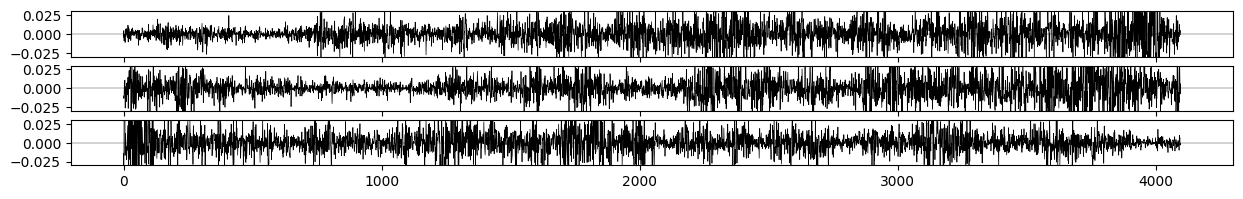

In [2]:
# create synthetic dataset
B = 2048  # number of realizations

lnx_mrw = MRWGenerator(T=4096+1, H=0.5, lam=0.2, cache_path=CACHE_PATH).load(R=B)
dlnx_mrw = np.diff(lnx_mrw, axis=-1)
print(f"Dataset shape (B, C, T): \n B = {dlnx_mrw.shape[0]} (nb of long time-series)," +
      f"\n C = {dlnx_mrw.shape[1]}    (nb of channels), \n T = {dlnx_mrw.shape[2]} (nb of time samples)")

fig, axes = plt.subplots(3, 1, figsize=(15,2))
for i, ax in enumerate(axes):
    ax.plot(dlnx_mrw[i,0,:], color='black', linewidth=0.5)
    ax.axhline(0.0, color='black', linewidth=0.25)
    ax.set_ylim(-0.03,0.03)

Context shape (B, C, T): 
 B = 6 : nb of dates to perform prediction on,
 C = 1   : nb of channels (C>1: would be multivariate), 
 T = 126 : nb of time samples retained in the past for shadowing


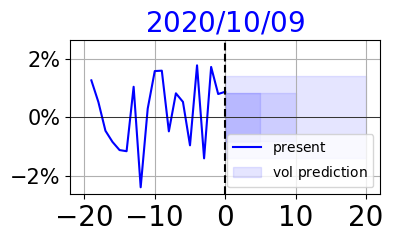

In [5]:
# observed data e.g. past time-series at different dates
# replace with the data you want to predict the future of
snp = SPDaily()
dlnx_context = windows(snp.dlnx, w=126, s=1024)
dates = windows(snp.dts.values, w=126, s=1024)
dlnx_context = dlnx_context[0,0,:,None,:]  # nb_windows x 1 x w
print(f"Context shape (B, C, T): \n B = {dlnx_context.shape[0]} : nb of dates to perform prediction on," +
      f"\n C = {dlnx_context.shape[1]}   : nb of channels (C>1: would be multivariate), \n T = {dlnx_context.shape[2]}" +
      " : nb of time samples retained in the past for shadowing")

# compute vol in the future 
vol_horizons = [5, 10, 20]
vols = realized_variance(dlnx_context[-1,0,-20:], Ts=vol_horizons, vol=True)
plot_volatility(dlnx_context[-1,0,-40:-20], vols, vol_horizons, date=pd.to_datetime(dates[-1,-20]), color_vol='blue')


# 2. Path Shadowing

Given observed log-returns gather the closest paths from the generated dataset.

In [8]:
# embedding for dimensionality reduction
embedding = Foveal(
    alpha=1.15,  # cover the past at exponential speed
    beta=0.9,  # look with a weight power-law decay of 0.9
    max_context=126  # look at half-year in the observed past
)

# distance between embedded paths
distance = RelativeMSE()

# object for path shadowing
obj = PathShadowing(
    embedding=embedding,
    distance=distance,
    dataset=dlnx_mrw,
    context=PredictionContext(horizon=252),  # the size of such paths in the future
)

# PERFORM PATH SHADOWING
distances, close_paths, _ = obj.shadow(
    dlnx_context, 
    k=8192,  # the number of closest paths (from generated dataset) to retain 
    n_splits=8,
    cuda=False  # set to True, if GPU available, for accelarations
)

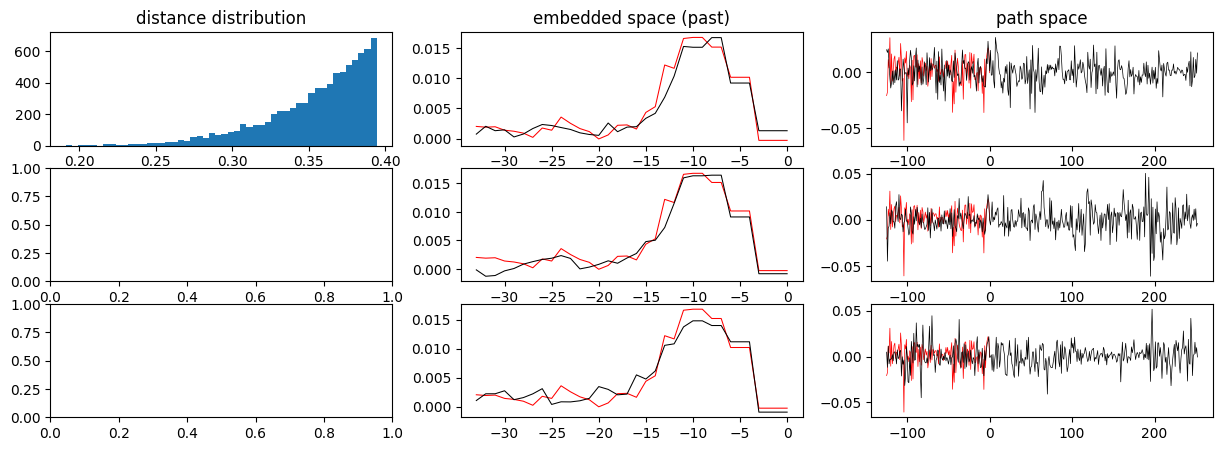

In [9]:
# some vizualization
i_date = -1

context_size = dlnx_context.shape[-1]  # nb of days in the past
d = embedding.dim  # embedding dimension
horizon = 252

# get 3 closest paths at this date
idces = np.argpartition(distances[i_date,:], 3)[:3]
dlnx_closest = np.stack([close_paths[i_date][i_path] for i_path in idces])

# embed them
dlnx_context_emb = embedding(_torch(dlnx_context))
dlnx_closest_emb = embedding(_torch(dlnx_closest))

fig, axes = plt.subplots(3, 3, figsize=(15, 5))
axes[0,0].set_title('distance distribution')
axes[0,0].hist(distances[i_date], bins=50)
axes[0,1].set_title('embedded space (past)')
for i, ax in enumerate(axes[:,1]):
    ts_past = np.arange(-d+1, 1)
    ax.plot(ts_past, dlnx_context_emb[i_date,0,:].flip(-1), color='red', linewidth=0.75)
    ax.plot(ts_past, dlnx_closest_emb[i,0,:].flip(-1), color='black', linewidth=0.75)
axes[0,2].set_title('path space')
for i, ax in enumerate(axes[:,2]):
    ts_past = np.arange(-context_size+1,1)
    ts = np.arange(-context_size+1,horizon+1)
    ax.plot(ts_past, dlnx_context[i_date,0,:], color='red', linewidth=0.5)
    ax.plot(ts, dlnx_closest[i,0,:], color='black', linewidth=0.5)


# Volatility Prediction

In [10]:
# example at a single date
# maturities 
horizons = np.array([7,25,75])

# the quantity to predict, should be a function of paths returning an array of statistics
# e.g. realized variance, takes a path, return a scalar per maturity
to_predict = lambda dlnx: realized_variance(dlnx, Ts=horizons, vol=True)[:,0,:]

# perform prediction by averaging over the k closest paths for each prediction date
# see method 'predict' for more direct way 
predictions, _ = obj.predict_from_paths(
    distances, 
    close_paths, 
    to_predict=to_predict,
    proba_name="softmax",
    eta=0.1
)

print(f"n_dates={predictions.shape[0]}, nb_maturities={predictions.shape[1]}")

n_dates=6, nb_maturities=3


# Option Pricing

Shows how to perform option pricing in two contexts


In [11]:
horizons = np.array([7,25,75])  # maturities in days
Ms = np.linspace(-2.0,2.0,9)  # rescaled log-moneyness
r = 0.00  # interest rate

### Smile at a given date

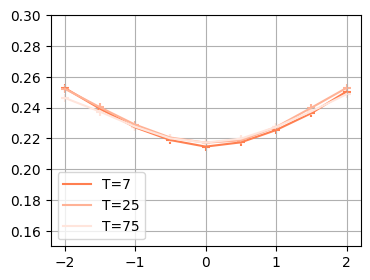

In [12]:
i_date = -1

# averaging operator in Hedged HMC
ave = Softmax(distances[i_date,:], eta=0.075)

# the shadowing paths extending the currently observed past
x = PriceData(dlnx=close_paths[i_date,:,0,context_size:], x_init=100.0).x

# HMC on such shadowing paths
smile_conditional = compute_smile(x, horizons, Ms, r, ave)

# plotting
_, ax = plt.subplots(1, 1, figsize=(4,3))
smile_conditional.plot(ax=ax, color='coral', rescale=True, legend=True)
ax.set_ylim(0.15,0.3);

### Average Smile

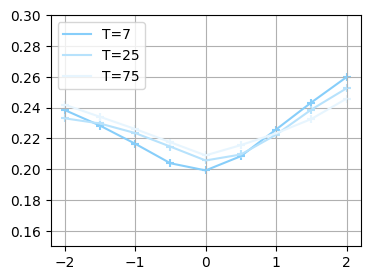

In [13]:
# snippets of MRW price trajectories
lnx_mrw_snippets = windows(lnx_mrw[0,0,:], w=252, s=1)
x = PriceData(lnx=lnx_mrw_snippets, x_init=100.0).x  # the price trajectories

# HMC on such snippets
smile_avg = compute_smile(x, horizons, Ms, r, ave=None)

# plotting
_, ax = plt.subplots(1, 1, figsize=(4,3))
smile_avg.plot(ax=ax, color='lightskyblue', rescale=True, legend=True)
ax.set_ylim(0.15,0.3);